<a href="https://colab.research.google.com/github/ayush554/NLP_Stance_Detection/blob/main/NLP_Stance_Detection_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stance Classification of Tweets using Transfer Learning
This notebook shows how *transfer learning*, an extension of deep learning, can be used for predicting Tweet stance toward a particular topic.

# 1. Motivation

The traditional approach to applying deep learning methods in NLP have involved feeding a model large amounts of labeled training data, and fitting the model's parameters to this data. In practice, natural language data is highly variable and can come in a variety of forms (tweets, blog posts, reviews etc.), and hence, a model trained for a particular language task does not generalize well to new data from another distribution. In addition, many natural language applications do not come with an abundance of labeled examples, and human annotation can get very expensive as the datasets get larger.

This offers good motivation to explore the notion of [transfer learning](http://ruder.io/transfer-learning/index.html#whatistransferlearning) - a machine-learning technique that has the ability to transfer knowledge to novel scenarios not encountered during training. While transfer learning has been ubiquitous throughout computer vision applications since the advent of huge datasets such as ImageNet, it is only since 2017-18 that significant progress has been made for transfer learning in NLP applications. There have been a string of interesting papers in 2018 that discuss the power of language models in natural language understanding and how they can be used to provide pre-trained representations of a language's syntax, which can be far more useful when training a neural network for previously unseen tasks.

Twitter data is a very interesting use case for transfer learning, mainly because the typical language syntax seen in Tweets is quite different from that which is used to train language models. For these reasons, the **2016 SemEval Stance Detection task** is chosen for studying the effectiveness of our transfer learning approach. The dataset, experiments and the evaluation criteria used are explained in below sections. 

The aim of this notebook is to highlight the development of a model that can help answer the following questions:
- How does our approach generalize to Twitter-specific language syntax?
- Are we able to achieve reasonable results (comparable to the winning team of SemEval 2016 Task 6) with *limited amounts of training data* and *limited computing resources*?
- How much fine-tuning effort is required to achieve reasonable results?

# 2. Approach
This section describes the 3-Layer LSTM architecture used for transfer learning, **ULMFit**. This is the architecture described in the well known paper by [Howard and Ruder, 2018](https://arxiv.org/pdf/1801.06146.pdf), that has been proven to generalize
well to unseen distributions. The goal is to see how *ULMFit* can perform in this particular Tweet stance classification task.


## 2.1 ULMFit Model Architecture
![title](assets/ulmfit_arch.png)

Source: [Howard and Ruder, 2018](https://arxiv.org/pdf/1801.06146.pdf)

To classify out-of-domain data (such as our Twitter data), the following techniques are applied from the ULMFit paper:

### Discriminative Fine-tuning
From the *ULMFit* paper, each layer of the model captures *different types of information*. Hence, it makes sense to fine-tune each layer differently, and this is done in *ULMFit* after extensive empirical testing and implementation updates. Rather than change each layer manually, we can use the implemented ratios, but adapt the multiplier that influences the learning rate for each layer. 

*ULMFit* also uses discriminative fine-tuning with regard to the SGD update as follows:

$\theta_{t}^{l} = \theta_{t-1}^{l} - \eta^{l} \cdot \nabla_{\theta^l} J{\theta} $

### 1-cycle learning rate policy
In the fine-tuning stage, a *1-cycle learning rate* policy is applied, which comes from this [report by Leslie Smith](https://arxiv.org/abs/1803.09820). It is a modification of the cyclical learning rate policy, which has been around for a long time, but the 1-cycle policy allows a large initial learning rate ($LR_{max}=10^{-3}$, for example), but decreases it by several orders of magnitude just at the last epoch. This seems to provide greater final accuracy. In the ULMFit implementation,  this 1-cycle policy has been tweaked and is referred to as *slanted triangular learning rate*.

### Gradual unfreezing
Rather than training all the layers at once during classification, the layers are "frozen" and the last layer is fine-tuned first, followed by the next layer before it, and so on. This avoids the phenomenon known as *catastrophic forgetting* (by fine-tuning all layers too aggressively). 

### Concatenated pooling
Because an input text can consist of hundreds or thousands of words, information might get lost if we only consider the last hidden state.

Hence, the hidden state at the last time step, $h_T$ is concatenated with *both* the max-pooled and mean-pooled representation of the hidden states over as many time steps as can fit in GPU memory.

$h_C = [h_T, maxpool(H), meanpool(H)]$

Where $H$ is the vector of all hidden states.

### 3-stage fine-tuning methodology
The classification task is done in a 3-stage process:
1. General-domain LM pretraining: ULMFit has a pretrained model generated using an AWD-LSTM (as per [Merity et al., 2017]((https://arxiv.org/pdf/1708.02182.pdf))) to develop a language model called ```Wikitext-103``` and was trained of 28,595 preprocessed Wikipedia articles, totalling to 103 million words. 
2. Target task *LM* fine-tuning: Since the data for the target will likely come from a different distribution, ULMFit allows us to use the pre-trained language model anf fine-tune it (using the above techniques) to adapt to the idiosyncrasies of the target data.
3. Target task *classifier* fine-tuning: Once we save the updated weights from the language model fine-tuning step, we can fine-tune the classifier with gradual unfreezing and the other techniques described above to perform  task-specific class prediction. 

Note that for this SemEval Tweet stance classification task, we only perform steps 2 and 3, and utilize the pretrained language model from the ```fastai``` database. 

# 3. Data

The training and test data consist of Tweets pertaining to five distinct topics, shown in [SemEval 2016: Task 6](http://alt.qcri.org/semeval2016/task6/). We only look at Task A: "Supervised Framework" in this notebook. The train and test data (including the gold) are in the the ```data/``` directory provided along with this repository.

The five topics for which Tweets are provided as part of the training data are given below. 

| Topic        
|:------------ | 
| Atheism     |
| Climate Change is a Real Concern  | 
| Feminist Movement | 
| Hillary Clinton  |
| Legalization of Abortion  | 

A more detailed breakdown of the tweets for this shared task is provided in [this link](http://www.saifmohammad.com/WebPages/StanceDataset.htm). 

## Size of dataset
The total number of Tweets (in the training set) available for this task is roughly 2700, which amounts to roughly 500-600 Tweets per topic. Thus, this can be considered a small dataset. 

![title](assets/stance_balance.png)

Upon inspecting the training data, it is clear that there is quite a large variance in terms of the number of Tweets in favor vs. those against a topic. There is quite a large variance *within* classes as well as *between* classes in the overall data. 

## 3.1 Pretrained language models

*ULMFit* uses its own pretrained language model ```wikitext-103``` that can be conveniently downloaded  from the ```fastai``` database hosted on AWS. 


## 3.2 Preprocess SemEval training data
This section discusses the steps used to prepare the data for transfer learning utilizing the ```fastai``` framework. In particular, the ```fastai.text``` library is designed to work very well with tabular data, hence, Pandas DataFrames are used to organize and filter the data.

In [ ]:
#@title
from fastai import *
from fastai.text import *
from pathlib import Path
import pandas as pd
import numpy as np
import re

### Define the path to train and test data for SemEval 2016 Task 6
The full data and evaluation files for this task is available on the [source page](http://alt.qcri.org/semeval2016/task6/index.php?id=data-and-tools). However, these have been included along with this repository for future reference. 

In [ ]:
#@title
path = Path('/content/sample_data/data')
trainfile = 'inputfile.txt'
testfile = 'test.txt'

Some of the characters in the training set are not *utf-8* encoded, hence we make sure that we only treat the characters that appear in the English language for this task.

In [ ]:
#@title
def clean_ascii(text):
    # function to remove non-ASCII chars from data
    return ''.join(i for i in text if ord(i) < 128)

In [ ]:
#@title
train_orig = pd.read_csv(path/trainfile, delimiter='\t', header=0, encoding = "latin-1")

In [ ]:
#@title
# Check that the latest 1.0.0 build of PyTorch has been installed 
# alongside fastai
import torch
print("Cuda available" if torch.cuda.is_available() is True else "CPU")
print("PyTorch version: ", torch.__version__)

Cuda available
PyTorch version:  1.8.1+cu101


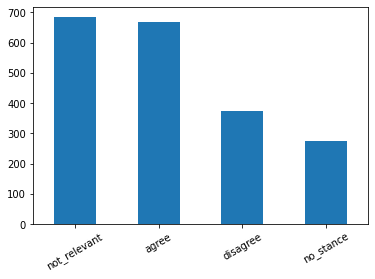

In [ ]:
#@title
# Plot value counts for rach stance in the dataset
train_orig['Stance'].value_counts().plot.bar(rot=30);

In [ ]:
#@title
print("SemEval 2016 Task 6 (subtask A) Tweet topics are:\n")
print("------------------------------------------")
for item in train_orig['Target'].unique():
    print(item)

SemEval 2016 Task 6 (subtask A) Tweet topics are:

------------------------------------------
More people will die as a result of a negative side effect to the COVID-19 vaccine than would actually die from the coronavirus.
The COVID-19 vaccine causes infertility or miscarriages in women.
The COVID-19 vaccine causes Bell's palsy.
Natural COVID-19 immunity is better than immunity derived from a COVID-19 vaccine.
RNA alters a person's DNA when taking the COVID-19 vaccine.
There are severe side effects of the COVID-19 vaccines, worse than having the virus.
The COVID-19 vaccine was developed to control the general population either through microchip tracking or nanotransducers in our brains.
The COVID-19 vaccine contains tissue from aborted fetuses.


### Apply the cleaning function to the 'Tweet' column of the training data

In [ ]:
#@title
train_orig['Tweet'] = train_orig['Tweet'].apply(clean_ascii)

In [ ]:
#@title
train_orig.head()

,ID,Target,Tweet,Stance
0,10001,More people will die as a result of a negative...,@meetnpatatas @RealMattCouch @Progressivemagi ...,agree
1,10002,The COVID-19 vaccine causes infertility or mis...,@armyveteran13 I said when the virus was first...,agree
2,10003,The COVID-19 vaccine causes infertility or mis...,Bombshell Interview With Del Bigtree: COVID Va...,agree
3,10004,The COVID-19 vaccine causes Bell's palsy.,"YOLO- berichtgeving: ""COVID Vaccine Caused 4...",agree
4,10005,Natural COVID-19 immunity is better than immun...,"@FatEmperor Natural immunity, I build up my bo...",no_stance


### Store the relevant information from training data 
ULMFit requires just the stance and the text data (i.e. tweets) for the language-model finetuning and classification steps, hence these are stored in a DataFrame.

In [ ]:
#@title
train = pd.concat([train_orig['Stance'], train_orig['Tweet']], axis=1)
train.tail()

,Stance,Tweet
1995,not_relevant,If the coronavirus vaccine doesn't cause autis...
1996,not_relevant,If the coronavirus vaccine doesn't cause autis...
1997,agree,I'm more concerned with the side effects of th...
1998,agree,I'm more concerned with the side effects of th...
1999,agree,Covid vaccine giving ppl of color Bell's palsy...


In [ ]:
#@title
# Write train to csv
train.to_csv(path/'train.csv', index=False, header=False)

# 4. Experimental Setup

Stance detection uses a *semi-supervised approach* where we reuse weights from a pretrained language model (in this case ```wikitext-103```) and perform multi-class classification on the training data over the three classes (*FAVOR*, *AGAINST* and *NONE*).

### Evaluation
The metric used to score the stance classification is **F-score**. The event organizers provide an [evaluation script](http://alt.qcri.org/semeval2016/task6/index.php?id=data-and-tools) that calculates the macro-average of F-score (FAVOR) and F-score (AGAINST) for task A. This compares our model's predicted stance for each Tweet against the gold reference.

The *perl* script provided by the organizers is used to generate an F- score. The evaluation script is in ```data/eval/``` and has the following usage:
    
    cd data/eval
    perl eval.pl -u

    ---------------------------
    Usage:
    perl eval.pl goldFile guessFile

    goldFile:  file containing gold standards;
    guessFile: file containing your prediction.

### Reference result
To have a benchmark to compare our results against, it makes sense to look at the winning paper for this shared task, from team *MITRE*, who [published their methodology and approach](https://arxiv.org/pdf/1606.03784.pdf). From this paper, it can be seen that *MITRE* used an LSTM-based deep learning approach and performed per-topic classification of Tweets to achieve an average macro F-score of **0.67**. 

### Stance Prediction
The predicted output stances on the test dataset is written out according to the format expected by the evaluation *perl* script, and the F-scores are published as per this evaluation.

# 5. Transfer Learning Stages

This notebook utilizes the refactored and updated version (```v1```) of *ULMFit* as implemented in the [fastai](https://github.com/fastai/fastai/tree/master/fastai)  GitHub repository. This requires an install of **Pytorch 1.0.0** ([released on December 7, 2018](https://developers.facebook.com/blog/post/2018/05/02/announcing-pytorch-1.0-for-research-production/)) to run since its development intended to move alongside PyTorch's own development cycle in the future. It is recommended to run this entire notebook in a virtual environment to avoid clashes with pre-existing installs of PyTorch.

The refactored code for *ULMFit* is much more high-level and abstracted than the original version that was used in the paper, so it doesn't make sense to rewrite the data manipulation code for text handling and tokenization from the ground up. We can take advantage of the powerful transfer learning functionality that is baked into ULMFit (obtained after months of fine-tuning and refactoring the source code by Fast.ai) instead! 

## 5.1 Language model finetuning: (SemEval Tweets only)
The pre-trained language model used is from [this work by Merity et al.](https://arxiv.org/pdf/1708.02182.pdf). Although we are working with Twitter whose content's structure that can be quite dissimilar to Wikipedia's sentence formulation, the hope is that the language understanding developed by the model, in combination with the fine-tuning techniques described in [Howard and Ruder's paper](https://arxiv.org/pdf/1801.06146.pdf), will allow us to at least transfer some knowledge for the purposes of classification of Tweet stance.

### Preprocess data for language model fine-tuning
The ```TextLMDataBunch```[ [source]](https://docs.fast.ai/text.data.html#TextLMDataBunch) class returns a "Databunch" type of object that is a custom object defined in fastai.text's API. Note that according to this class definition, a significant amount of data pre-processing is going on under the hood. 

- Initialize the language model with the pre-trained vocabulary's weights
- Create a custom data loader that "batchifies" the target task's vocabulary, i.e. split it up into batches for processing on the GPU
- Introduce randomness into the batches, but without breaking up the sentence sequences using techniques [borrowed from language modeling](https://arxiv.org/pdf/1708.02182.pdf).
- Tokenize the target task's vocabulary and increase the efficiency of tokenization (for large tasks) using multi-threading
 

In [ ]:
#@title
# Language model data
data_lm = TextLMDataBunch.from_csv(path, 'train.csv', min_freq=1)

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


Note that in this case, we specify a minimum word frequency of 1 (i.e. words that appear just once in the data are given the tag ```<unk>``` during tokenization.

In [ ]:
#@title
# Save the language and classifier model data for re-use
data_lm.save()

In [ ]:
#@title
data_lm.show_batch()

idx,text
0,covid vaccine xxbos xxmaj just a guess based on a long life of experience . xxmaj the xxup covid vaccine will end up more deadly and unhealthy for those that survive than the virus alone . xxbos xxmaj bell 's palsy is a known vax reaction . xxup bp is n't the only paralysis caused by vax so is xxmaj guillain - xxmaj barr syndrome . i know i had
1,"xxmaj united xxmaj states have presented with serious side effects from the xxup covid vaccine , xxup cdc admits xxup url "" xxbos xxmaj the covid-19 vaccine is harmful , or at least might be harmful . xxbos xxmaj the xxmaj covid-19 vaccine is fake ! xxbos @albertothomas xxmaj which solution do you want ? xxmaj what this thread is stating , [ xxup covid is synthetic and alters your"
2,from the xxmaj covid-19 vaccine xxrep 4 . they wo n't tell that part xxbos i rather take my chances with the xxmaj covid vaccine than the actual virus . xxbos @tofromthe360 xxmaj the unknown risks of the mrna vaccine can be greater than the known risks of xxup covid . xxbos xxmaj you know how anti vaxxers push the narrative that vaccines are made from aborted embryos because they
3,". xxmaj wake up people # saynotodepopulation # justiceforamaechi # playlikeplay xxbos xxmaj the vaccine is going to be worse than the virus . xxmaj that 's what xxmaj covid-21 will be . xxbos xxmaj we are all going to get a xxup dna upgrade tomorrow , except for those who got the xxup covid vaccine . xxbos xxmaj can mrna vaccines alter your xxup dna ? xxmaj more of"
4,"of adverse side effects for the covid vaccine ? xxmaj if it 's higher than the death rate for the actual virus , i 'll take my chances . xxbos xxmaj side effects of the xxmaj covid -19 vaccine xxup url xxbos if you unlock your phone by scanning your fingerprint or face , you do n't have to worry about the covid vaccine planting a microchip in you ."


We only need to run the above tokenization step once, and save the data. All the data goes to a local folder named ```tmp/```. For a large added vocabulary, the above tokenization step can take a while, hence we save them and restart the notebook from the next cell (if we close our session).

The tokenization technique used by ```fastai.text``` is quite advanced, and uses quite a few tricks to capture semantic meaning from the text. Unlike typical NLTK-type tokenization, here we are not converting the Tweets to lowercase and removing information from the base text - that would result in a tremendous loss of information that our model could use to gather an understanding of our new task's vocabulary.

Instead, a number of added tokens are applied so that minimal information is lost. A full list of all the tokenization rules used are [here](https://docs.fast.ai/text.transform.html#Rules). 

As an example, the ```xxmaj``` token [[source]](https://github.com/fastai/fastai/blob/1c5c007e10a187f4a048a3ee8137016534259768/fastai/text/transform.py#L71) indicates that there is capitalization of the word, either in part or in full. "The" will be tokenized as "xxmaj the". For words that are full capitalized, such as "I AM SHOUTING"; it is tokenized as "xxup i xxup am xxup shouting". The tokenizer uses spaCy's underlying tokens, but adds tags in a very smart way that balances capturing semantic meaning while reducing the number of overall tokens, so it is both powerful and efficient. 

The tokenization process described above is highly efficient, in part thanks to the power of *SpaCy* and also due to the multi-threading wrappers implemented by Fast.ai on top of Spacy's tokenizer. As a result, a really large language model's vocabulary (of millions of words) can also be effectively tokenized in a reasonable time. 

### Define learner object for language model finetuning
We define a learner object that uses the tokenized language model data, that is organized into batches for the GPU, and feed it a pre-trained language model. 

We use the ```wt_103_v1``` model that was refined after re-training using the more efficient ```fastai v1``` library. The data (```lstm_wt103.pth```) is downloaded through an AWS-hosted link (accessed through the ```fastai.datasets``` interface), and stored locally. All the data in the language model file is numericalized and stored in a way that the learner can efficiently pick up tokens in float form. In addition to the language model, there is also an additional pickle object ```itos_wt103.pkl``` that is similar to the ```torchtext``` definition of "integer-to-string" - this contains the list of unique tokens in word form, so that we can map the tokens back to strings if necessary.

In [ ]:
#@title
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.1)

### Print the structure of the language model RNN 
We can examine the architecture of the 3-layer LSTM used in ULMFit as shown below. For the language model fine-tuning, we define the embeddings based on the the target task vocabulary size. A single linear output layer is defined  that updates the weights once we pass the input through the network.

In [ ]:
#@title
list(learn.model.children())

[AWD_LSTM(
   (encoder): Embedding(4720, 400, padding_idx=1)
   (encoder_dp): EmbeddingDropout(
     (emb): Embedding(4720, 400, padding_idx=1)
   )
   (rnns): ModuleList(
     (0): WeightDropout(
       (module): LSTM(400, 1152, batch_first=True)
     )
     (1): WeightDropout(
       (module): LSTM(1152, 1152, batch_first=True)
     )
     (2): WeightDropout(
       (module): LSTM(1152, 400, batch_first=True)
     )
   )
   (input_dp): RNNDropout()
   (hidden_dps): ModuleList(
     (0): RNNDropout()
     (1): RNNDropout()
     (2): RNNDropout()
   )
 ), LinearDecoder(
   (decoder): Linear(in_features=400, out_features=4720, bias=True)
   (output_dp): RNNDropout()
 )]

### Find the optimum learning rate 
```fastai.train``` [source](https://github.com/fastai/fastai/blob/050080be574cb1260462bbd03e9600e43e7a54b1/fastai/train.py#L23) provides a convenient utility to search through a range of learning rates to find the optimum one for our dataset. 

The idea is that our optimization function needs to use a learning rate that is an order of magnitude below the point at which the loss starts to diverge. We can quickly find this as shown below. 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


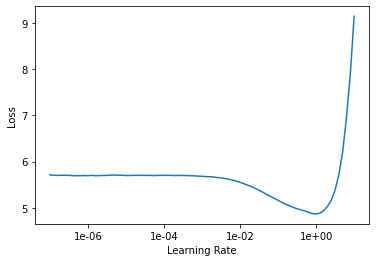

In [ ]:
#@title
learn.lr_find(start_lr=1e-8, end_lr=1e2)
learn.recorder.plot()

### Run the ```language_model_learner``` class
The pre-trained language model quickly downloads from the ```fastai```'s AWS link, so there is no need to download it separately. [```drop_mult```] is the multiplier applied to the dropout in the language learner. As per the ULMFit paper, we use a custom dropout for each language model layer, and the ```drop_mult```just scales a [numpy array of these dropouts](https://github.com/fastai/fastai/blob/1c5c007e10a187f4a048a3ee8137016534259768/fastai/text/learner.py#L15) which remain in the same relative ratio to one another. These numbers have been obtained through empirical tuning for a range of language tasks, and we took note of this during our extensive reading on this task.

In [ ]:
#@title
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.1)
learn.fit_one_cycle(cyc_len=1, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.588064,5.236752,0.198065,00:02


### Unfreeze the entire model 
To train the language model during fine-tuning, we unfreeze all the layers and then perform training for a reasonable time until we obtain a low enough validation loss. For a larger target vocabulary, these hyperparameters might need to be modified, and teh training time would be significantly longer, but for this SemEval task, we have a very small additional vocabulary to fine-tune the language model on, so it is really quick.


In [ ]:
#@title
learn.unfreeze()
learn.fit_one_cycle(cyc_len=20, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.161946,4.607910,0.240402,00:02
1,4.832207,4.191795,0.288690,00:02
2,4.535787,3.988767,0.324182,00:02
3,4.254678,3.776578,0.353348,00:02
4,3.954870,3.595392,0.376042,00:02
5,3.631924,3.453906,0.400298,00:02
6,3.277639,3.463776,0.419643,00:02
7,2.915834,3.489054,0.429762,00:03
8,2.565663,3.558904,0.431920,00:03
9,2.240226,3.592429,0.437277,00:03


In [ ]:
#@title
# Save the fine-tuned encoder
learn.save_encoder('ft_enc')

## 5.2 Train the Classifier: SemEval Tweets only

For classification, the [winning paper for the SemEval 2016](https://www.aclweb.org/anthology/S/S16/S16-1074.pdf) task (team MITRE) describe in section $5$ of their paper that they achieved their highest average F1 score when they trained 5 *distinct* classifiers, i.e. a separate training task for each of the 5 topics in the training data. 

Hence, in this notebook we only perform classification for one *topic* at a time. Evaluation of the predicted classes is also done on a per-topic basis. 

### Identify the 5 topics in our training data

In [ ]:
#@title
# for item in train_orig.Target.unique():
#     print(item)

More people will die as a result of a negative side effect to the COVID-19 vaccine than would actually die from the coronavirus.
The COVID-19 vaccine causes infertility or miscarriages in women.
The COVID-19 vaccine causes Bell's palsy.
Natural COVID-19 immunity is better than immunity derived from a COVID-19 vaccine.
RNA alters a person's DNA when taking the COVID-19 vaccine.
There are severe side effects of the COVID-19 vaccines, worse than having the virus.
The COVID-19 vaccine was developed to control the general population either through microchip tracking or nanotransducers in our brains.
The COVID-19 vaccine contains tissue from aborted fetuses.


### Specify the topic we want to classify for
We specify the topic name exactly as the training data does, and use it to subset the Pandas DataFrame.

In [ ]:
#@title
# Write train to csv
train.to_csv(path/'train1.csv', index=False, header=False)

### Create classification dataloader
For classification, the ```TextClasDataBunch```  [[source](https://docs.fast.ai/text.data.html#TextClasDataBunch)] dataloader used is slightly different. Just like the language model custom data loader described in the previous section, it does a lot under the hood. The classification data loader tokenizes the training data, but batchifies the data differently from the language model data loader - for classification, we perform sorting so as to group all large sentences together, and smaller sentences together - and pad them to have all batches of roughly the same length, followed by randomizing these batches so that we don't introduce additional bias during training.

Just like before, we define the learner object used for classification. Note that we feed in the entire vocabulary of the training data to the classifier. We once more specify a minimum word frequency of 1 (i.e. words that appear just once in the data are given the tag ```<unk>```.

In [ ]:

# Classifier model data
data_clas = TextClasDataBunch.from_csv(path, 'train1.csv', vocab=data_lm.train_ds.vocab,min_freq=1, bs=32)
data_clas.save()

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
learn = text_classifier_learner(data_clas,AWD_LSTM,drop_mult=0.5)
learn.load_encoder('ft_enc')
learn.freeze()

Note that we begin the training with all the outer layers as frozen. The fine-tuned language model is read in, and we use a dropout multiplier as shown above. 

For training the classifier, we apply "gradual unfreezing", to avoid "catastrophic forgetting" as explained in section $3.3$ of [Howard and Ruder's paper](https://arxiv.org/pdf/1801.06146.pdf). In addition to gradual unfreezing, 

### Just as before, find optimum learning rate for the classifier

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


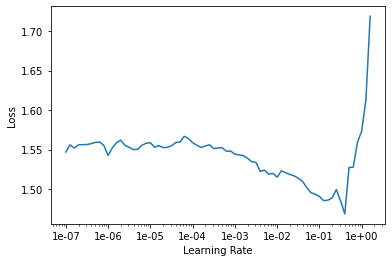

In [ ]:

learn.lr_find(start_lr=1e-8, end_lr=1e2)
learn.recorder.plot()

### Carefully train the classifier
During classification, we gradually unfreeze layers as shown below. This helps us obtain a better classification accuracy than if we were to aggressively train all the layers at once. 

In [ ]:
#@title
learn.fit_one_cycle(cyc_len=1, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.469406,1.215937,0.462500,00:02


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
# #@title
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-4,1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.341401,1.189906,0.497500,00:02


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
# #@title
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1e-5,5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.228179,1.079992,0.555000,00:03


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
#@title
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-5,1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.142209,1.066289,0.550000,00:03
1,1.108103,1.010678,0.585000,00:04
2,1.065653,1.023291,0.587500,00:04
3,1.026013,1.006201,0.590000,00:04


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

### Cross-tabulate the predictions for each class
The below table shows the predicted classes for the topic in concern. The actual evaluation of the F1 score of the classification result is done at a later step.

In [ ]:
#@title
# get predictions
preds, targets = learn.get_preds()
predictions = np.argmax(preds, axis=1)

pd.crosstab(predictions, targets)

col_0,0,1,2,3
row_0,,,,
0,91,28,18,24
1,5,33,3,5
2,4,2,8,6
3,34,16,19,104


In [ ]:
# print(predictions)

tensor([[ 1, 52, 46,  ..., 52, 52, 52],
        [ 0, 10, 52,  ..., 10, 10, 10],
        [ 0, 41, 10,  ..., 37, 37, 37],
        ...,
        [16, 15, 35,  ..., 15, 15, 15],
        [28, 26, 57,  ..., 26, 26, 26],
        [10,  2, 12,  ...,  2,  2,  2]])


## Evaluate the predicted results from the classifier (SemEval tweets only)
We read in the test dataset and store in a Pandas DataFrame as shown.

In [ ]:
#@title
test = pd.read_csv(path/testfile, delimiter='\t', header=0, encoding = "latin-1")
test = test.drop(['ID'], axis=1)
# test['Tweet'] = test['Tweet'].apply(clean_ascii)
test.head()

,Target,Tweet,Stance
0,There are severe side effects of the COVID-19 ...,"Just so y'all know, it's possible that the vac...",UNKNOWN
1,Natural COVID-19 immunity is better than immun...,@JCope222 Vaccine is untested for safety. Peop...,UNKNOWN
2,Natural COVID-19 immunity is better than immun...,@catturd2 Why would antibodies formed from rec...,UNKNOWN
3,There are severe side effects of the COVID-19 ...,I started thinking about the long term effects...,UNKNOWN
4,Natural COVID-19 immunity is better than immun...,I like vaccine herd immunity over infection he...,UNKNOWN


Since we do not yet know the stance for the test set, it is marked as "UNKNOWN". 

### Filter the test data set based on topic we are classifying for

In [ ]:
#@title
test_pred = test[['Target', 'Tweet']]
# test_pred = test_pred.loc[test_pred['Target'] == topic]
test_pred.tail()


,Target,Tweet
1206,The COVID-19 vaccine causes infertility or mis...,"@talkRADIO @PatrickChristys URL: ""Information ..."
1207,The COVID-19 vaccine causes infertility or mis...,COVID Vaccine Could Make The Virus Far More De...
1208,The COVID-19 vaccine causes Bell's palsy.,At least four individuals contracted Bell's Pa...
1209,RNA alters a person's DNA when taking the COVI...,And RNA changes your DNA. Do not take the vacc...
1210,The COVID-19 vaccine causes infertility or mis...,Covid vaccine is Not safe it changes our genes...


In [ ]:
print(learn.predict("@WillWinWon @mynameisjerm BILL GATES Admits Covid Vaccine ALTERS DNA URL")[0])

agree


### Apply the learner's ```predict``` method to produce our prediction

In [ ]:
#@title
test_pred['Stance'] = test_pred['Tweet'].apply(lambda row: str(learn.predict(row)[0]))

In [ ]:
#@title
test_pred.tail()

,Target,Tweet,Stance
1206,The COVID-19 vaccine causes infertility or mis...,"@talkRADIO @PatrickChristys URL: ""Information ...",no_stance
1207,The COVID-19 vaccine causes infertility or mis...,COVID Vaccine Could Make The Virus Far More De...,agree
1208,The COVID-19 vaccine causes Bell's palsy.,At least four individuals contracted Bell's Pa...,agree
1209,RNA alters a person's DNA when taking the COVI...,And RNA changes your DNA. Do not take the vacc...,agree
1210,The COVID-19 vaccine causes infertility or mis...,Covid vaccine is Not safe it changes our genes...,agree


### Output the predicted dataset to a text file for comparison with the gold reference

In [ ]:
#@title
test_pred.to_csv('/content/sample_data/data/predicted.txt', sep='\t', index=True,
                 header=['Target', 'Tweet', 'Stance'], index_label='ID')